# Large Bubbles Error Detection

This file contains the algorithm to detect the large bubbles inside the cardboards

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os

In [47]:
def undistort_image(image, mtx, dist):
    """
    Undistort the image using the camera matrix and distortion coefficients.
    """
    h, w = image.shape[:2]
    new_camera_mtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
    undistorted_img = cv.undistort(image, mtx, dist, None, new_camera_mtx)
    return undistorted_img

def mask_image(image, kernelSize):
    # Recieves blurred image and returns a mask of the contour
    contour_mask = np.zeros_like(image, dtype=np.uint8)

    # Thresholding the imnage OTSU gives us the optimal threshold value
    _ , th_Bin_OTSU = cv.threshold(image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    # Find the contours in the image
    contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # We search the biggest contour Area Based
    contour_max = max(contours, key=cv.contourArea)

    # Bounding box of the biggest contour
    x, y, w, h = cv.boundingRect(contour_max)

    # We expand the ROI
    margin = 10  # Additional pixels to the ROI
    x_roi = max(x - margin, 0)
    y_roi = max(y - margin, 0)
    w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
    h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)  #With ROI coordinates we can select the desired part of the image
    # We use the ROI found in the previous step
    roi = th_Bin_OTSU[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

    # We apply the canny on the ROI
    canny_edges_roi = cv.Canny(roi, 50, 110, L2gradient=True)
    # print("Borders detected:", np.count_nonzero(canny_edges_roi))

    # Dilate the edges
    kernel = np.ones((2, 2), np.uint8)
    canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)
    
    # Crear máscara del mismo tamaño que la imagen, inicialmente negra
    contour_mask = np.zeros_like(image, dtype=np.uint8)
    
    # Obtener el contorno más grande en la imagen (dentro del ROI binarizado)
    contours, _ = cv.findContours(canny_edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv.contourArea)

    # Usar contorno real en lugar del convex hull
    contour_offset = max_contour + np.array([[[x_roi, y_roi]]])

    # Dibujar el contorno exterior (relleno blanco) sobre la máscara
    cv.drawContours(contour_mask, [contour_offset], -1, color=255, thickness=-1)

    # Aplicar erosión para "encoger" el área del contorno
    mask_size = kernelSize # tamaño del kernel de erosión
    kernel = np.ones((mask_size, mask_size), np.uint8)  # puedes ajustar el tamaño para más o menos reducción
    contour_mask_eroded = cv.erode(contour_mask, kernel, iterations=1)
    
    return contour_mask_eroded

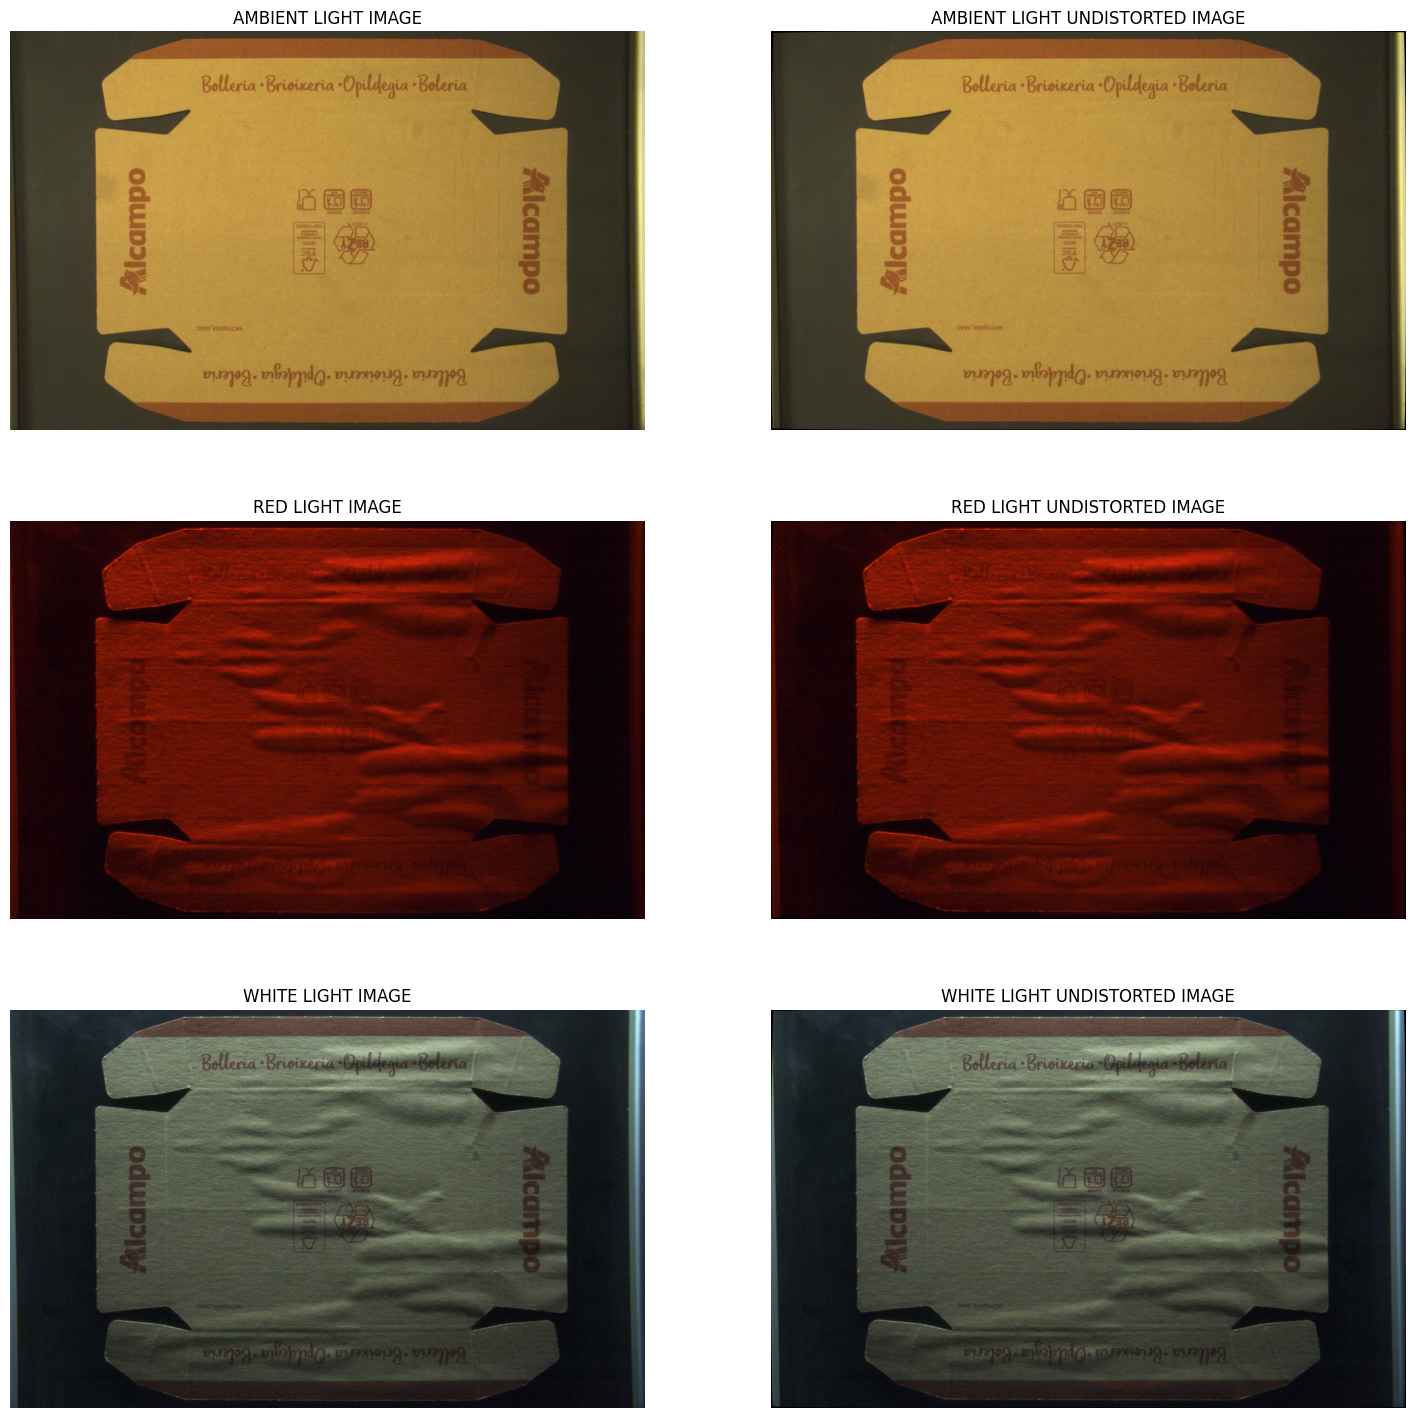

In [48]:
# Working directory
baseFolder = os.getcwd()

# image Number
imageNumber = 1

if imageNumber == 1:
    # Load the image with Ambient Light
    AL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '1_ROOM_LIGHT.png'))

    # Load the image with the red Light
    RL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '1_RED_LIGHT_2.png'))

    # Load the iage with the white Light
    WL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '1_WHITE_LIGHT.png'))
else:
    # Load the image with Ambient Light
    AL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '2_WHITE_LIGHT_2.png'))

    # Load the image with the red Light
    RL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '2_RED_LIGHT_2.png'))

    # Load the iage with the white Light
    WL_img = cv.imread(os.path.join(baseFolder, 'FINAL_PHOTOS', 'BUBBLES_RETAKE', '2_WHITE_LIGHT_1.png'))

# Loading the camera parameters obtained from the calibration process
cameraParameters = np.load(baseFolder + "/calibration/camera_lens_12mm.npz")

# We extract the camera matrix and distortion coefficients, through the keys in the dictionary
mtx = cameraParameters['mtx']
dist = cameraParameters['dist']
res = cameraParameters['res']

# Undistort the images using the camera parameters
udst_AL_img = undistort_image(AL_img, mtx, dist)
udst_RL_img = undistort_image(RL_img, mtx, dist)
udst_WL_img = undistort_image(WL_img, mtx, dist)

plt.figure(figsize=(18, 18))

plt.subplot(3, 2, 1)
plt.imshow(cv.cvtColor(AL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("AMBIENT LIGHT IMAGE")
plt.subplot(3, 2, 2)
plt.imshow(cv.cvtColor(udst_AL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("AMBIENT LIGHT UNDISTORTED IMAGE")

plt.subplot(3, 2, 3)
plt.imshow(cv.cvtColor(RL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("RED LIGHT IMAGE")
plt.subplot(3, 2, 4)
plt.imshow(cv.cvtColor(udst_RL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("RED LIGHT UNDISTORTED IMAGE")

plt.subplot(3, 2, 5)
plt.imshow(cv.cvtColor(WL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("WHITE LIGHT IMAGE")
plt.subplot(3, 2, 6)
plt.imshow(cv.cvtColor(udst_WL_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("WHITE LIGHT UNDISTORTED IMAGE")

plt.show()


## Region of Interest

We are going to focus on the ambient ligth image for finding the borders of the cardboard and use only this section of the image, for that reason we are going to start by doing an optimal threshold of the image, using OTSU

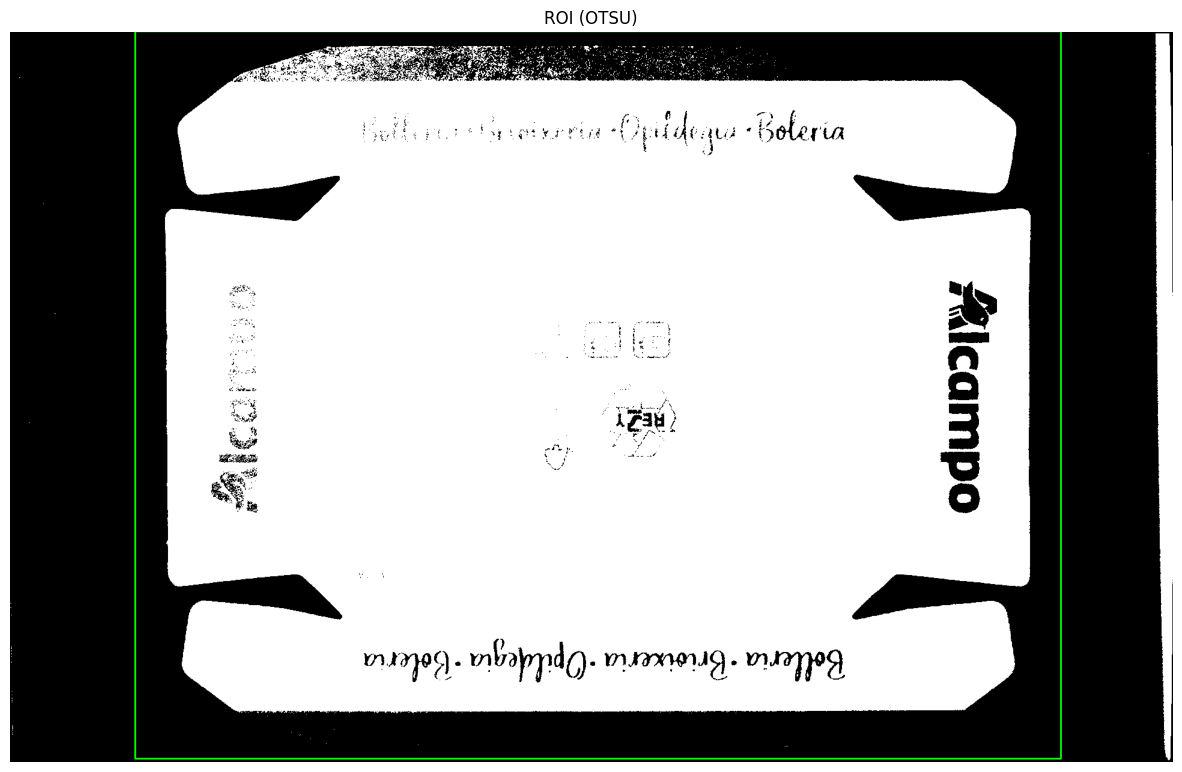

In [49]:
# Thresholding the imnage OTSU gives us the optimal threshold value
udst_AL_gray = cv.cvtColor(udst_AL_img, cv.COLOR_BGR2GRAY)
_ , th_Bin_OTSU = cv.threshold(udst_AL_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

# Find the contours in the image
contours, _ = cv.findContours(th_Bin_OTSU, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We search the biggest contour Area Based
contour_max = max(contours, key=cv.contourArea)

# Bounding box of the biggest contour
x, y, w, h = cv.boundingRect(contour_max)

# We expand the ROI
margin = 50  # Additional pixels to the ROI
x_roi = max(x - margin, 0)
y_roi = max(y - margin, 0)
w_roi = min(w + 2 * margin, th_Bin_OTSU.shape[1] - x_roi)
h_roi = min(h + 2 * margin, th_Bin_OTSU.shape[0] - y_roi)

# Draw a green rectangle using BGR
img_with_roi = cv.cvtColor(th_Bin_OTSU, cv.COLOR_GRAY2BGR)
cv.rectangle(img_with_roi, (x_roi, y_roi), (x_roi + w_roi, y_roi + h_roi), (0, 255, 0), 2)

# We show the image with the ROI detected
plt.figure(figsize=(15, 10))
plt.imshow(img_with_roi)
plt.title("ROI (OTSU)")
plt.axis("off")
plt.show()

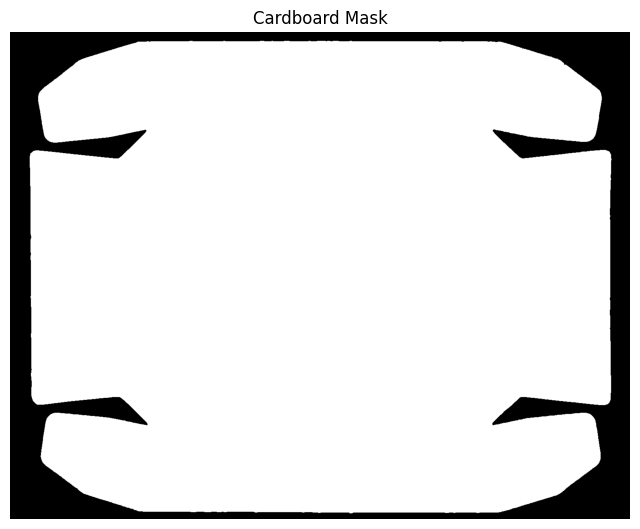

In [50]:
# Wa apply a gaussian blur to the image to reduce noise
blur = cv.GaussianBlur(udst_AL_gray, (5, 5), 0)

# Start by extracting the ROI from the blurre image
roi = blur[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

# We apply the Canny edge detection algorithm to the ROI
canny_edges_roi = cv.Canny(roi, 40, 130, L2gradient=True)

# We are going to dilate the edges to make them more pronounced
kernel = np.ones((2, 2), np.uint8)
canny_edges = cv.dilate(canny_edges_roi, kernel, iterations=1)

# We had to add a morphological operation to close small gaps in the edges
# Required to connect the small red pieces in the borders of the cardboard
kernel_close = np.ones((5, 5), np.uint8)
closed = cv.morphologyEx(canny_edges, cv.MORPH_CLOSE, kernel_close)

# This final step is to assure that the edges are well defined and the 
# cardboard contour is clearly visible
dilated = cv.dilate(closed, np.ones((3, 3), np.uint8), iterations=1)

# We find the contours in the image
contours, _ = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# We take the largest contour based on area
max_contour = max(contours, key=cv.contourArea)

# We create the cardboard mask
cardboard_mask = np.zeros_like(canny_edges, dtype=np.uint8)
cv.drawContours(cardboard_mask, [max_contour], -1, 255, thickness=cv.FILLED)

# 9. Visualizar resultado
plt.figure(figsize=(8, 8))
plt.imshow(cardboard_mask, cmap='gray')
plt.title("Cardboard Mask")
plt.axis("off")
plt.show()

## Analysis on the Red Light photo

Based on the found ROI and cardboard mask we are ready to work on the cardboard iluminated in tangential direction

0 1210 208 1541


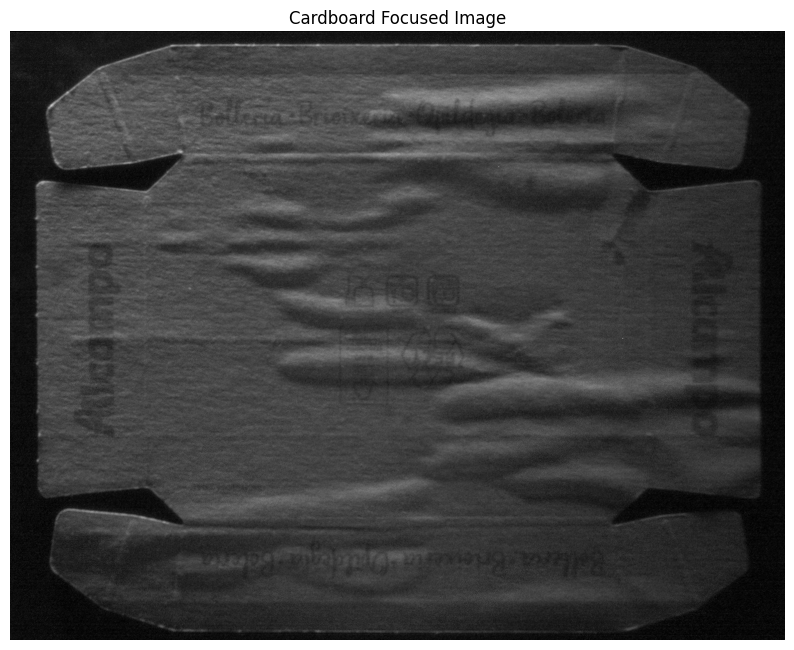

In [51]:
# For the analysis we need to convert the image to grayscale
udst_RL_gray = cv.cvtColor(udst_RL_img, cv.COLOR_BGR2GRAY)
udst_WL_gray = cv.cvtColor(udst_WL_img, cv.COLOR_BGR2GRAY)

print(y_roi, h_roi, x_roi, w_roi)

# Start by extracting the ROI from the Red Ligthed image
roi_RL_img = udst_RL_gray[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
roi_AL_img = udst_AL_gray[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
roi_WL_img = udst_WL_gray[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]

# We apply the mask to the red light image
cardboard_img = cv.bitwise_and(roi_RL_img, cardboard_mask)

# Mostrar el resultado
plt.figure(figsize=(10, 8))
plt.imshow(roi_RL_img, cmap='gray')
plt.title("Cardboard Focused Image")
plt.axis("off")
plt.show()

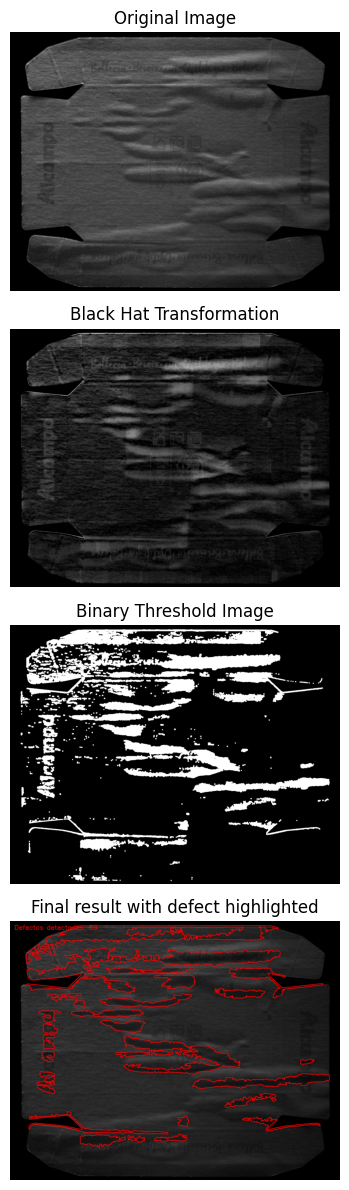

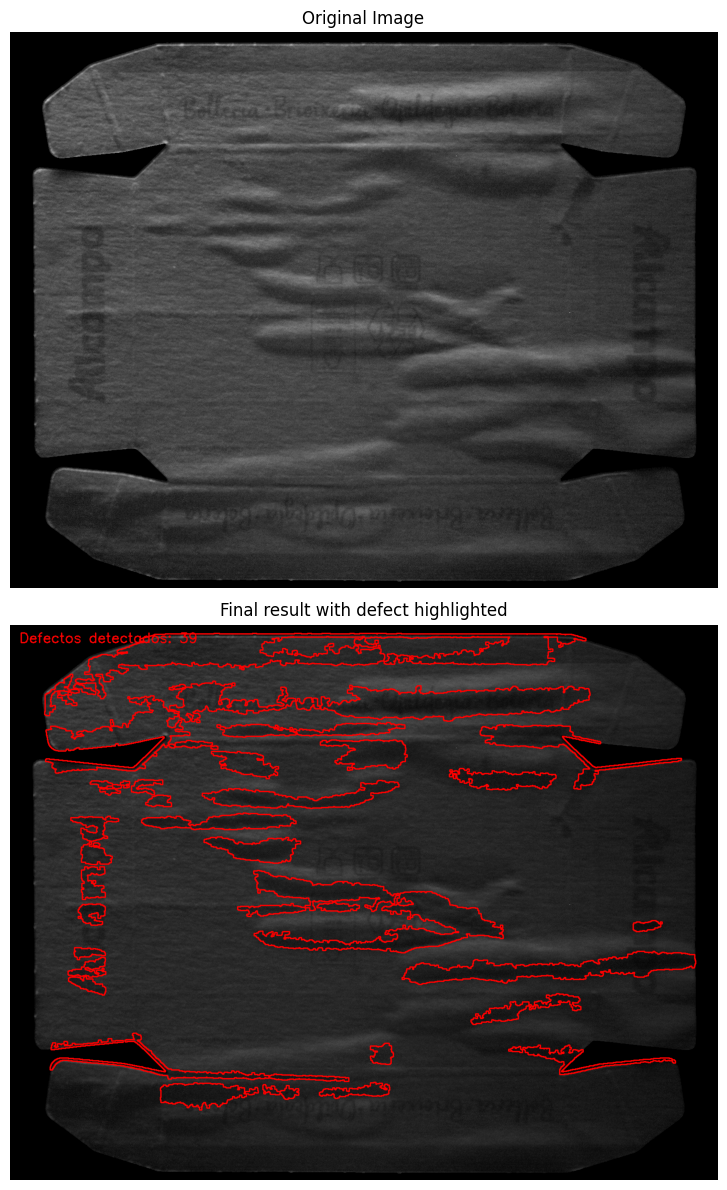

In [52]:
# We apply a Gaussian blur to the cardboard image to reduce the noise
gray = cv.GaussianBlur(cardboard_img, (5, 5), 0)

# The "Black Hat" morphological operation is used to highlight dark regions on a light background.
kernel_size = (75, 75)
kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)

blackhat = cv.morphologyEx(gray, cv.MORPH_BLACKHAT, kernel)

# We apply the cardbord mask to the blackhat image
blackhat = cv.bitwise_and(blackhat, cardboard_mask)

# We employ a binary threshold to create a mask of the defects
_, thresh = cv.threshold(blackhat, 18, 255, cv.THRESH_BINARY)

# We dilate the thresholded image to enhance the visibility of defects
thresh = cv.dilate(thresh, None, iterations=2)

# Find contours in the thresholded image
contours, _ = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

output_image = cv.cvtColor(cardboard_img, cv.COLOR_GRAY2BGR)

min_defect_area = 1000
detected_defects = 0

for contour in contours:
    if cv.contourArea(contour) > min_defect_area:
        detected_defects += 1
        # Dibujar en rojo
        cv.drawContours(output_image, [contour], -1, (0, 0, 255), 2)

# Cambiar el color del texto a rojo
cv.putText(output_image, f"Defectos detectados: {detected_defects}", (20, 40), 
            cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# 6. Mostrar los resultados
plt.figure(figsize=(20, 12))
plt.subplot(4, 1, 1)
plt.imshow(cardboard_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(4, 1, 2)
plt.imshow(blackhat, cmap='gray')
plt.title('Black Hat Transformation')
plt.axis('off')
plt.subplot(4, 1, 3)
plt.imshow(thresh, cmap='gray')
plt.title('Binary Threshold Image')
plt.axis('off')
plt.subplot(4, 1, 4)
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title('Final result with defect highlighted')
plt.axis('off')
plt.tight_layout()
plt.show()

# 6. Mostrar los resultados
plt.figure(figsize=(20, 12))
plt.subplot(2, 1, 1)
plt.imshow(cardboard_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 1, 2)
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB))
plt.title('Final result with defect highlighted')
plt.axis('off')
plt.tight_layout()
plt.show()
